In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18, ResNet18_Weights
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import utils

torch.manual_seed(42069)
# if gpu available else cpu
device = torch.device(0) if torch.cuda.is_available() else torch.device('cpu')
TRAIN_MEAN = [0.5036, 0.4719, 0.3897]
TRAIN_STD = [0.2623, 0.2577, 0.2671]
classes = ['butterfly','cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']

## Przygotowanie danych

In [2]:
# zdefiniowanie operacji na kazdym obrazie w zbiorze
transform = transforms.Compose([
    transforms.RandomResizedCrop(256),  #  na 256x256
    transforms.RandomHorizontalFlip(),  # wycinamy losowy fragment 128x128
    transforms.ToTensor(),              # obrazy zamieniamy na tensory,
    # srednie i odchylenia po kanałach całęgo zbioru,
    #  wyliczone wczesniej za pomocą utils.data_normalize_values
    transforms.Normalize(TRAIN_MEAN, TRAIN_STD) 
])

# loader danych z batchami
train_data = ImageFolder(root='dataset/train/', transform=transform)
test_data = ImageFolder(root='dataset/test/', transform=transform)
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)

### Przykladowe obrazy ze zbioru

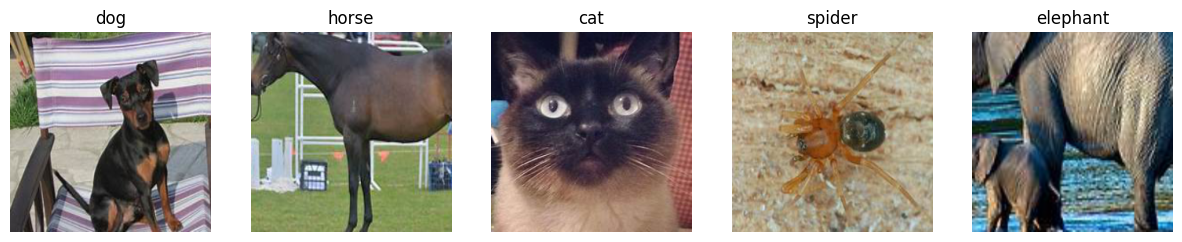

In [3]:
# transformacja odwrotnej normalziacji na potrzeby wizualizacji
inv_normalize = transforms.Normalize(
    mean = [-m/s for m,s in zip(TRAIN_MEAN, TRAIN_STD)],
    std = [1/s for s in TRAIN_STD]
)
# first batch
data, labels = next(iter(train_loader))
fig, ax = plt.subplots(1, 5, figsize=(15,15))
for i in range(5):
    # reverse normalization i zmiana kolejnosci wymiarow by wyswietlic
    img = inv_normalize(data[i])
    img = img.permute(1,2,0)
    ax[i].imshow(img)
    ax[i].axis('off')
    ax[i].set_title(classes[labels[i].item()])

## Uczenie klasyfikatora

In [4]:
# RESNET18 z wagami przetrenowanymi na zbiorze IMAGENET
res_net_model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
# dostosowanie ostatniego layeru do problemu
res_net_model.fc = nn.Linear(res_net_model.fc.in_features, len(classes))
# inicjalizacja wag w warstwie wyjsciowej
nn.init.xavier_uniform_(res_net_model.fc.weight)

res_net_model = res_net_model.to(device)
metrics = utils.train_fine_tuning(
    model = res_net_model, 
    learning_rate= 5e-5, 
    train_loader=train_loader,
    test_loader=test_loader,
    device=device, num_epochs=5, param_group=True
)

Progress: 1/5 epochs
Epoch: 1, Loss 0.547, Train acc: 0.829, Test acc: 0.899
Progress: 2/5 epochs
Epoch: 2, Loss 0.329, Train acc: 0.894, Test acc: 0.912
Progress: 3/5 epochs
Epoch: 3, Loss 0.294, Train acc: 0.905, Test acc: 0.915
Progress: 4/5 epochs
Epoch: 4, Loss 0.292, Train acc: 0.904, Test acc: 0.923
Progress: 5/5 epochs
Epoch: 5, Loss 0.271, Train acc: 0.913, Test acc: 0.923
